# Intro and content

Apache Spark is of the most popular big data frameworks. It's fast and easy to use compared to its predecesors. Its high-level APIs available in differents languages like Python or Scala makes this framework appealling for many Data Scientists that need to handle large amounts of data.

In this notebook, we are gonna explore the Netflix subscription fee in different countries dataset(https://www.kaggle.com/prasertk/netflix-subscription-price-in-different-countries) with Pyspark. Even though this is a very small dataset that could be handled with other non-big data tools like Pandas, this exercise serves the purpose of learning and practicising some of the most common operations for data analysis with Pyspark.


# **1. Initialize Pyspark and load dataset**

## Install pyspark and create a SparkSession

In [2]:
# create SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("NetflixEDA").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/02/20 10:54:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

## Load data

In [4]:
# data path
PATH = "/kaggle/input/netflix-subscription-price-in-different-countries/Netflix subscription fee Dec-2021.csv"

`inferSchema=True` Infers the input schema automatically from data.

In [5]:
# create a Spark dataframe from .csv file
# automatically infer schema
df_auto = spark.read.csv(PATH, inferSchema=True, header=True)

In [6]:
# inspect infered schema
df_auto.printSchema()

root
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Total Library Size: integer (nullable = true)
 |-- No. of TV Shows: integer (nullable = true)
 |-- No. of Movies: integer (nullable = true)
 |-- Cost Per Month - Basic ($): double (nullable = true)
 |-- Cost Per Month - Standard ($): double (nullable = true)
 |-- Cost Per Month - Premium ($): double (nullable = true)



We can also define the schema manually.

In [7]:
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType

# define schema
manualSchema = StructType([
    StructField("Country_code", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("Total Library Size", IntegerType(), True),
    StructField("No. of TV Shows", IntegerType(), True),
    StructField("No. of Movies", IntegerType(), True),
    StructField("Cost Per Month - Basic ($)", FloatType(), True),
    StructField("Cost Per Month - Standard ($)", FloatType(), True),
    StructField("Cost Per Month - Premium ($)", FloatType(), True),
])

In [8]:
df = spark.read.csv(PATH, schema=manualSchema, header=True)

In [9]:
type(df)

pyspark.sql.dataframe.DataFrame

In [10]:
df.printSchema()

root
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Total Library Size: integer (nullable = true)
 |-- No. of TV Shows: integer (nullable = true)
 |-- No. of Movies: integer (nullable = true)
 |-- Cost Per Month - Basic ($): float (nullable = true)
 |-- Cost Per Month - Standard ($): float (nullable = true)
 |-- Cost Per Month - Premium ($): float (nullable = true)



We have string, integer and float data types, and all the columns can have null values.

We are gonna rename the columns to avoid issues with symbols, etc.

In [11]:
new_names = [
    'countryCode',
    'country',
    'totalLibrarySize',
    'numberTVShows',
    'numberMovies',
    'monthlyCostBasic',
    'monthlyCostStandard',
    'monthlyCostPremium'
]

df = df.toDF(*new_names)

# **2. Quick glance at the data** <a class="anchor" id="2"></a>

[Go back to table of contents](#0.1)

Let's gain some understanding of the data.

In [12]:
# show first 5 rows
df.show(5)

+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+
|countryCode|  country|totalLibrarySize|numberTVShows|numberMovies|monthlyCostBasic|monthlyCostStandard|monthlyCostPremium|
+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+
|         ar|Argentina|            4760|         3154|        1606|            3.74|                6.3|              9.26|
|         au|Australia|            6114|         4050|        2064|            7.84|              12.12|             16.39|
|         at|  Austria|            5640|         3779|        1861|            9.03|              14.67|             20.32|
|         be|  Belgium|            4990|         3374|        1616|           10.16|              15.24|             20.32|
|         bo|  Bolivia|            4991|         3155|        1836|            7.99|              10.99|             13.99|
+-------

By using the method `.limit()` and `.toPandas()`, we can convert a Spark DataFrame into a Pandas table display.

In [13]:
# visualize as Pandas table
df.limit(5).toPandas()

countryCode    country  totalLibrarySize  numberTVShows  numberMovies  \
0          ar  Argentina              4760           3154          1606   
1          au  Australia              6114           4050          2064   
2          at    Austria              5640           3779          1861   
3          be    Belgium              4990           3374          1616   
4          bo    Bolivia              4991           3155          1836   

   monthlyCostBasic  monthlyCostStandard  monthlyCostPremium  
0              3.74                 6.30            9.260000  
1              7.84                12.12           16.389999  
2              9.03                14.67           20.320000  
3             10.16                15.24           20.320000  
4              7.99                10.99           13.990000

The dataset contains 6 variables:
- Country_code
- Country
- Total Library Size: Sum of No. of TV Shows and No. of Movies
- No. of TV Shows
- No. of Movies
- Cost Per Month - Basic ($)

- Cost Per Month - Standard ($)

- Cost Per Month - Premium ($)

With the exception of Total Library Size, all the variables are self-explanatory.

In [14]:
# describe the dataset
df.describe().show()

+-------+-----------+---------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|summary|countryCode|  country| totalLibrarySize|     numberTVShows|      numberMovies|  monthlyCostBasic|monthlyCostStandard|monthlyCostPremium|
+-------+-----------+---------+-----------------+------------------+------------------+------------------+-------------------+------------------+
|  count|         65|       65|               65|                65|                65|                65|                 65|                65|
|   mean|       null|     null|5314.415384615385|3518.9538461538464|1795.4615384615386|  8.36846140714792|  11.98999995451707|15.612922998575064|
| stddev|       null|     null|980.3226333124288| 723.0105555671635| 327.2797483099835|1.9378186644783801| 2.8639787613790837| 4.040672256237365|
|    min|         ar|Argentina|             2274|              1675|               373|              1.97|                3.

The `.describe()` method gives us a good overview of the dataset.

The dataset includes information from 65 countries and, as we can depict from the counts, there are not missing values. The largest library has 7325 titles whereas the smallest has 2274 titles. The average number of TV shows is 3518 and the average number of Movies is 1795 and so we can say that there tend to be more TV shows than movies in Netflix libraries.

The average monthly costs for the different subscriptions are:
- Basic -> `$8.36`
- Standard -> `$11.99`
- Premium -> `$15.61`

The max and min monthly costs for the different subscriptions are:
- Basic -> Max monthly cost = `$12.88`; Min monthly cost = `$1.97`
- Standard -> Max monthly cost = `$20.46`; Min monthly cost = `$3.0`
- Premium -> Max monthly cost = `$26.96`; Min monthly cost = `$4.02`

In [15]:
# look at all the countries in the dataset
df.select("countryCode", "country").show(df.count())

+-----------+--------------+
|countryCode|       country|
+-----------+--------------+
|         ar|     Argentina|
|         au|     Australia|
|         at|       Austria|
|         be|       Belgium|
|         bo|       Bolivia|
|         br|        Brazil|
|         bg|      Bulgaria|
|         ca|        Canada|
|         cl|         Chile|
|         co|      Colombia|
|         cr|    Costa Rica|
|         hr|       Croatia|
|         cz|       Czechia|
|         dk|       Denmark|
|         ec|       Ecuador|
|         ee|       Estonia|
|         fi|       Finland|
|         fr|        France|
|         de|       Germany|
|         gi|     Gibraltar|
|         gr|        Greece|
|         gt|     Guatemala|
|         hn|      Honduras|
|         hk|     Hong Kong|
|         hu|       Hungary|
|         is|       Iceland|
|         in|         India|
|         id|     Indonesia|
|         ie|       Ireland|
|         il|        Israel|
|         it|         Italy|
|         jp| 

The dataset contains countries in Europe, US, Asia and Oceania. As this is a small dataset that we are using for learning purposes, we can convert this column into a Pandas dataframe and plot the countries in a worldwide map.

In [16]:
# some imports
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pycountry

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [17]:
# load geodata from geopandas
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

pop_est      continent                      name iso_a3  gdp_md_est  \
0     920938        Oceania                      Fiji    FJI      8374.0   
1   53950935         Africa                  Tanzania    TZA    150600.0   
2     603253         Africa                 W. Sahara    ESH       906.5   
3   35623680  North America                    Canada    CAN   1674000.0   
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

In [18]:
# countries in our dataset
countries_data = df.select("countryCode", "country").toPandas()
countries_data.head()

countryCode    country
0          ar  Argentina
1          au  Australia
2          at    Austria
3          be    Belgium
4          bo    Bolivia

In [19]:
# convert country code to iso a3
country_codes = countries_data["countryCode"].values.tolist()
country_codes_a3 = []
names = []
for country in pycountry.countries:
    if country.alpha_2.lower() in country_codes:
        country_codes_a3.append(country.alpha_3)
        names.append(country.name)

In [20]:
# check that all the countries code have been converted
assert len(country_codes_a3) == 65

In [21]:
# add to data
countries_data["iso_a3"] = country_codes_a3
countries_data["name"] = names

In [22]:
print(countries_data.shape)
countries_data.head()

(65, 4)


countryCode    country iso_a3       name
0          ar  Argentina    ARG  Argentina
1          au  Australia    AUS  Australia
2          at    Austria    AUT    Austria
3          be    Belgium    BEL    Belgium
4          bo    Bolivia    BGR   Bulgaria

In [23]:
# check that there's geodata for all the countries in the dataset
countries[countries["iso_a3"].isin(countries_data["iso_a3"])].shape

(57, 6)

Let's try to find the remaining 8 countries.

In [24]:
# missing countries
import numpy as np

print(np.setdiff1d(countries_data["iso_a3"], countries[countries["iso_a3"].isin(countries_data["iso_a3"])]["iso_a3"]))

['FRA' 'GIB' 'HKG' 'LIE' 'MCO' 'NOR' 'SGP' 'SMR']


In [25]:
# try to find them manually
# FRA -> France
countries.loc[countries["name"] == "France"]

pop_est continent    name iso_a3  gdp_md_est  \
43  67106161    Europe  France    -99   2699000.0   

                                             geometry  
43  MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...

In [26]:
# GIB -> Gibraltar
countries.loc[countries["name"].str.contains("Gibraltar")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

In [27]:
# HKG -> Hong Kong
countries.loc[countries["name"].str.contains("Hong Kong")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

In [28]:
# LIE -> Liechtenstein
countries.loc[countries["name"].str.contains("Liechtenstein")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

In [29]:
# MCO -> Monaco
countries.loc[countries["name"].str.contains("Monaco")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

In [30]:
# NOR -> Norway
countries.loc[countries["name"].str.contains("Norway")]

pop_est continent    name iso_a3  gdp_md_est  \
21  5320045    Europe  Norway    -99    364700.0   

                                             geometry  
21  MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...

In [31]:
# SGP -> Singapur
countries.loc[countries["name"].str.contains("Singapur")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

In [32]:
# SMR -> San Marino
countries.loc[countries["name"].str.contains("Marino")]

Empty GeoDataFrame
Columns: [pop_est, continent, name, iso_a3, gdp_md_est, geometry]
Index: []

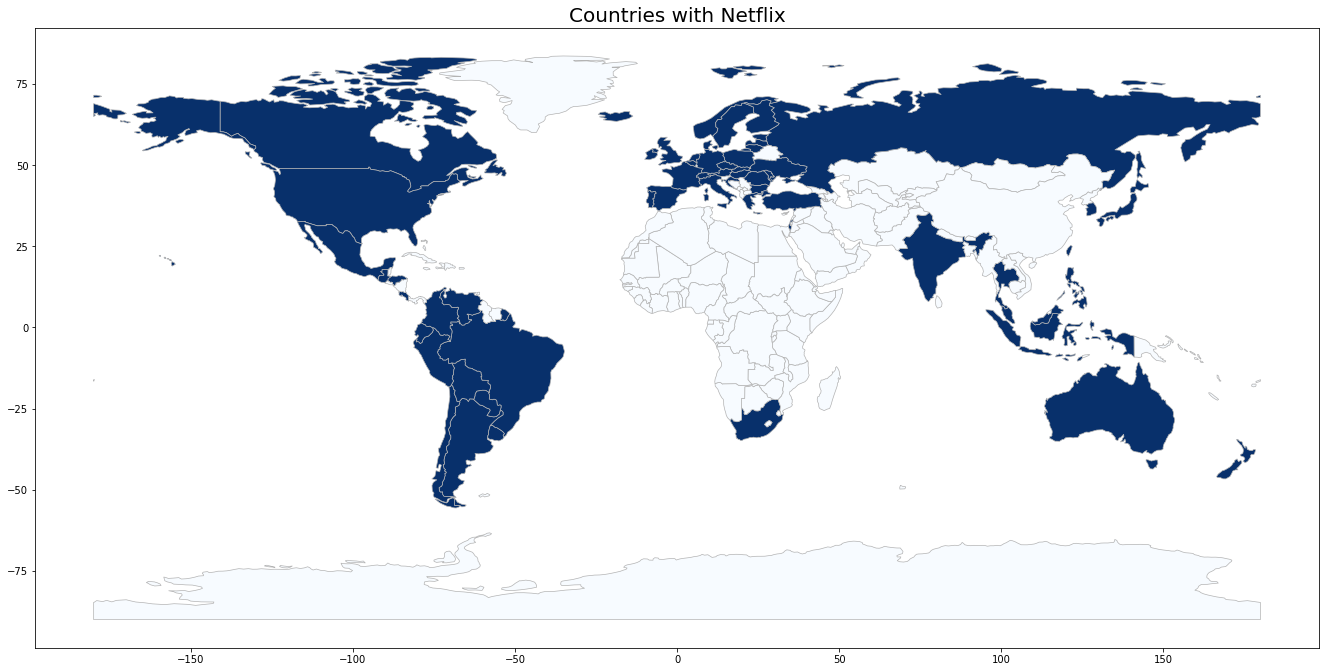

In [33]:
# create a flag for plotting
countries["flag"] = countries["iso_a3"].map(lambda x: 1 if x in countries_data["iso_a3"].values.tolist() else 0)
# manually add france and norway
countries.loc[countries["name"] == "France", "flag"] = 1
countries.loc[countries["name"] == "Norway", "flag"] = 1
# plot
fig, ax = plt.subplots(1, figsize=(23, 13))
countries.plot(column="flag", linewidth=0.7, ax=ax, cmap="Blues", edgecolor='0.7')
plt.title("Countries with Netflix", fontsize=20)
plt.show();

Note 'GIB', 'HKG', 'LIE', 'MCO', 'SGP' and 'SMR' are not included in the visualization.


In [34]:
# check for missing values in the data
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+-----------+-------+----------------+-------------+------------+----------------+-------------------+------------------+
|countryCode|country|totalLibrarySize|numberTVShows|numberMovies|monthlyCostBasic|monthlyCostStandard|monthlyCostPremium|
+-----------+-------+----------------+-------------+------------+----------------+-------------------+------------------+
|          0|      0|               0|            0|           0|               0|                  0|                 0|
+-----------+-------+----------------+-------------+------------+----------------+-------------------+------------------+



# **3. Exploratory Data Analysis (EDA)** <a class="anchor" id="3"></a>

[Go back to table of contents](#0.1)

## EDA with Pandas Profiling

We can easily create a nice interactive report with Pandas profiling. We need to convert the Spark DataFrame into a Pandas DataFrame, that we can do in this case.

Note there already exists a [Spark df profiling](https://github.com/julioasotodv/spark-df-profiling) but there are still some dependencies issues.

In [35]:
# drop string cols
no_str_df = df.drop("countryCode", "country")

In [36]:
from pandas_profiling import ProfileReport

profile = ProfileReport(no_str_df.toPandas(), title="Report", explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlations with Pyspark

By looking at correlations, we can better understand the relationships between variables in our dataset. The report we've created with Pandas Profiling comes very handy for checking correlations but let's see how we can calculate correlations with Pyspark.

The MLlib library facilitates the calculation of the correlation matrix with the method `.corr()`. First, we are going to calculate the Pearson correlation and therefore, assume linear relationships between variables and that variables follow a normal distribution.

__Pearson's Correlation__

The Pearson correlation coefficient is calculated as follows:

$$r_p = \frac{COV(X, Y)}{std(X) * std(Y)}$$

where COV is the covariance between the 2 variables and std the standard deviation.

In [37]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vector_col = "corr_vars"
assembler = VectorAssembler(inputCols=no_str_df.columns, outputCol=vector_col)
df_vector = assembler.transform(no_str_df).select(vector_col)
corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()

/opt/conda/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [38]:
corr_matrix_df = spark.createDataFrame(corr_matrix, no_str_df.columns)
corr_matrix_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    totalLibrarySize|       numberTVShows|        numberMovies|    monthlyCostBasic| monthlyCostStandard|  monthlyCostPremium|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|  0.9711459692193751|  0.8499574080179413|-0.06287684999485411|-0.05519986931782366| -0.0715210569386201|
|  0.9711459692193751|                 1.0|  0.6997860988691629|-0.00381400892363...|0.002284882447594...|-0.01109980833468...|
|  0.8499574080179413|  0.6997860988691629|                 1.0|-0.17991345555167165|-0.17039146376748412|-0.18971058430966617|
|-0.06287684999485411|-0.00381400892363...|-0.17991345555167165|                 1.0|   0.898534825160934|  0.8209140310212804|
|-0.05519986931782366|0.002284882447594...|-0.17039146376748412|   0.898534825160934|                 1.

In [39]:
plot_corr = corr_matrix_df.toPandas()
plot_corr.index = corr_matrix_df.columns
plot_corr.style.background_gradient(cmap='Blues')

The correlation matrix based on PCC doesn't show correlation between cost of subcriptions and library size. We could say that there are other factors that influence the differences in price of a netflix subscription. Only the number of movies show a weak negative correlation with costs, meaning that, assuming a linear correlation between variables, the cost of a subscription goes down as the number of movies increases.
 
The total size of the library is strongly correlated with the number of TV shows and the number of movies, as expected. If we needed to train a statiscal model using this features, this would be a problem as some algorithms like linear regression suffer from multicolinearity. We could either drop the `totalLibrarySize` variable or, alternatively, drop `numberTVShows` and `numberMovies`.

__Spearman’s Correlation__

If two or more variables are non-linearly correlated or variables don't follow a normal distribution, we shouldn't use Pearson's correlation. We can use Spearman’s correlation coefficient, that only assumes a monotonic association between the variables. Spearman's correlation could also be used to measure linear relationships between variables but it won't result in strong correlation coefficients.

The Spearman's correlation coeffient is calculates as follows:

$$r_s = \frac{COV(rank(X), rank(Y))}{std(rank(X)) * std(rank(Y))}$$

In [40]:
# compute spearman correlation coefficients
corr_matrix_s = Correlation.corr(df_vector, vector_col, "spearman").collect()[0][0].toArray().tolist()
corr_matrix_s_df = spark.createDataFrame(corr_matrix_s, no_str_df.columns)
corr_matrix_s_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    totalLibrarySize|       numberTVShows|        numberMovies|    monthlyCostBasic| monthlyCostStandard|  monthlyCostPremium|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|  0.9648030216385556|  0.8304588477422528|-0.01304269734527...| 0.08905556108997549| 0.06125899804498413|
|  0.9648030216385556|                 1.0|    0.70313234910995|0.027239294646323114| 0.14421890889615852| 0.11586873137906702|
|  0.8304588477422528|    0.70313234910995|                 1.0| -0.2158243121931077|-0.13665765822228126|-0.15907360596095219|
|-0.01304269734527...|0.027239294646323114| -0.2158243121931077|                 1.0|  0.8194576722398096|  0.6840374030205204|
| 0.08905556108997549| 0.14421890889615852|-0.13665765822228126|  0.8194576722398096|                 1.

In [41]:
plot_corr_s = corr_matrix_s_df.toPandas()
plot_corr_s.index = corr_matrix_s_df.columns
plot_corr_s.style.background_gradient(cmap='Blues')

The positive correlation between number of TV shows and costs, specially in Standard and Premium subscriptions, is slightly higher with Spearman correlation. This means that as the number of TV shows increases, the cost of Standard and Premium subscriptions slightly increases as well, and vice-versa.

The negative correlation between the number of movies and costs is a bit stronger as well, compared to Pearson correlation coefficients.

__However, these variables are still weakly correlated with costs. There must be other factors that have a stronger impact of the cost of a Netflix subscription.__

## Countries with most expensive Netflix subscriptions

We can measure cost in absolute terms and also relative to the library size. We'll use the 3 different subscription costs to compute the average cost.

In [42]:
from pyspark.sql.functions import avg

# define function to compute average across 3 cols
cols = [col('monthlyCostBasic'), col('monthlyCostStandard'), col('monthlyCostPremium')]
avgColsFunc = sum(x for x in cols) / len(cols)

In [43]:
# Create new df with the avg cost col
dfWithAvg = df.withColumn('AverageSubsCost', avgColsFunc)
dfWithAvg.show(5)

+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+------------------+
|countryCode|  country|totalLibrarySize|numberTVShows|numberMovies|monthlyCostBasic|monthlyCostStandard|monthlyCostPremium|   AverageSubsCost|
+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+------------------+
|         ar|Argentina|            4760|         3154|        1606|            3.74|                6.3|              9.26| 6.433333079020183|
|         au|Australia|            6114|         4050|        2064|            7.84|              12.12|             16.39|12.116666158040365|
|         at|  Austria|            5640|         3779|        1861|            9.03|              14.67|             20.32|14.673333485921225|
|         be|  Belgium|            4990|         3374|        1616|           10.16|              15.24|             20.32|15.240000406901041|

In [44]:
# Top 10 countries with most expensive subscriptions in absolute terms
dfWithAvg.select("country", "AverageSubsCost") \
    .orderBy(col("AverageSubsCost").desc()).limit(10).show()

+-------------+------------------+
|      country|   AverageSubsCost|
+-------------+------------------+
|Liechtenstein|20.099999745686848|
|  Switzerland|20.099999745686848|
|      Denmark|15.546666463216146|
|      Belgium|15.240000406901041|
|       France|15.240000406901041|
|       Israel|15.050000508626303|
|       Sweden|14.933333079020182|
|    Gibraltar|14.673333485921225|
|      Austria|14.673333485921225|
|        Italy|14.673333485921225|
+-------------+------------------+



In [45]:
# Create new df with the avg cost col relative to library size
dfWithAvgRel = dfWithAvg.withColumn('AverageSubsCostPerTitle', dfWithAvg.AverageSubsCost / dfWithAvg.totalLibrarySize)
dfWithAvgRel.show(5)

+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+------------------+-----------------------+
|countryCode|  country|totalLibrarySize|numberTVShows|numberMovies|monthlyCostBasic|monthlyCostStandard|monthlyCostPremium|   AverageSubsCost|AverageSubsCostPerTitle|
+-----------+---------+----------------+-------------+------------+----------------+-------------------+------------------+------------------+-----------------------+
|         ar|Argentina|            4760|         3154|        1606|            3.74|                6.3|              9.26| 6.433333079020183|   0.001351540562819366|
|         au|Australia|            6114|         4050|        2064|            7.84|              12.12|             16.39|12.116666158040365|   0.001981790343153478|
|         at|  Austria|            5640|         3779|        1861|            9.03|              14.67|             20.32|14.673333485921225|   0.002601654873390288

In [46]:
# Top 10 countries with most expensive subscriptions in relative terms
dfWithAvgRel.select("country", "AverageSubsCostPerTitle") \
    .orderBy(col("AverageSubsCostPerTitle").desc()).limit(10).show()

+-------------+-----------------------+
|      country|AverageSubsCostPerTitle|
+-------------+-----------------------+
|Liechtenstein|   0.006594488105540305|
|   San Marino|   0.006352092418147716|
|      Croatia|   0.004963353944642562|
|  Switzerland|   0.003650562975969...|
|       Sweden|   0.003424291006425...|
|      Denmark|   0.003410852668542...|
|      Finland|   0.003348166234315...|
|      Belgium|   0.003054108297976...|
|       Norway|   0.002934334556121287|
|      Moldova|   0.002866819118648003|
+-------------+-----------------------+



## Countries with cheapest Netflix subscriptions


In [47]:
# Top 10 countries with less expensive subscriptions in absolute terms
dfWithAvg.select("country", "AverageSubsCost") \
    .orderBy(col("AverageSubsCost").asc()).limit(10).show()

+------------+-----------------+
|     country|  AverageSubsCost|
+------------+-----------------+
|      Turkey|2.996666590372721|
|       India|5.950000127156575|
|   Argentina|6.433333079020183|
|    Colombia|7.033333460489909|
|      Brazil|7.226666768391927|
|     Ukraine|8.463333129882812|
|        Peru| 8.56000010172526|
| Philippines|9.140000025431315|
|South Africa|9.630000432332357|
|       Chile| 9.90666643778483|
+------------+-----------------+



In [48]:
# Top 10 countries with most expensive subscriptions in relative terms
dfWithAvgRel.select("country", "AverageSubsCostPerTitle") \
    .orderBy(col("AverageSubsCostPerTitle").asc()).limit(10).show()

+-----------+-----------------------+
|    country|AverageSubsCostPerTitle|
+-----------+-----------------------+
|     Turkey|   6.459725351094463E-4|
|      India|   0.001018312532458767|
|  Argentina|   0.001351540562819366|
|   Colombia|   0.001409203257962314|
|Philippines|   0.001436655143890...|
|     Brazil|   0.001453472801366035|
|    Hungary|   0.001555781574090...|
|    Czechia|   0.001568600738143487|
|    Ukraine|   0.001586081920892581|
|   Slovakia|   0.001604359185517...|
+-----------+-----------------------+

